# Notes

Fourth iteration of the modeling:
- modulirized data processing
- model serialization

In [1]:
import os 
import re
import csv
import json
import math
import random

from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# Constants

In [2]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'patients_augmented')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

**TODO** Implement augmenation and patients sessions for the new data set

# Data prep

### Build training set

In [3]:
CONFIG = {
    'SEQ_MAX_LEN': 801,
    'NUM_EXERCISES': 9,
    'NUM_CLASSES': 6,
    'REGIONS':json.load(open(os.path.join('settings', 'pois_region_tpcnn.json'))),
    'AUGMENTED': True
}

In [4]:
CONFIG

{'SEQ_MAX_LEN': 801,
 'NUM_EXERCISES': 9,
 'NUM_CLASSES': 6,
 'REGIONS': {'LefteyeMidbottom': 'upper',
  'LefteyeMidtop': 'upper',
  'LefteyeInnercorner': 'upper',
  'LefteyeOutercorner': 'upper',
  'LefteyebrowInner': 'upper',
  'LefteyebrowCenter': 'upper',
  'RighteyeMidbottom': 'upper',
  'RighteyeMidtop': 'upper',
  'RighteyeInnercorner': 'upper',
  'RighteyeOutercorner': 'upper',
  'RighteyebrowInner': 'upper',
  'RighteyebrowCenter': 'upper',
  'NoseTip': 'lower',
  'MouthLowerlipMidbottom': 'lower',
  'MouthLeftcorner': 'lower',
  'MouthRightcorner': 'lower',
  'MouthUpperlipMidtop': 'lower',
  'ChinCenter': 'lower',
  'ForeheadCenter': 'upper',
  'LeftcheekCenter': 'lower',
  'RightcheekCenter': 'lower'},
 'AUGMENTED': True}

input for global region
801 is length of a series in excercise 
each series consist from 63 value, 21 POIs, each POI has 3 values: x,y,z

overall length of a series is 7209 (in paper 8019?)

In [5]:
i = 0 
exercise_ids = set()
for file_name in os.listdir(dir_exercises):
    ids = file_name.split('.')
    exercise_id = f'{ids[0]}'
    exercise_ids.add(exercise_id)
exercise_ids = sorted(list(exercise_ids))

In [6]:
len(exercise_ids)

2419

In [7]:
def pad_excercise_poi(data, poi):
    return tf.keras.preprocessing.sequence.pad_sequences(
        [
            data['pois'][poi]['xs'],
            data['pois'][poi]['ys'],
            data['pois'][poi]['zs']
        
        ],
        padding='pre',
        maxlen=CONFIG['SEQ_MAX_LEN'],
        dtype='float32')

In [8]:
def session_data(exercise_id, augmented = None):
    global_region = None
    upper_region = None
    lower_region = None
    exercises_data = None
    
    if augmented:
        exercises_data = json.load(open(os.path.join(dir_exercises_augmented, f'{exercise_id}_{augmented}.json')))
    else:
        exercises_data = json.load(open(os.path.join(dir_exercises, f'{exercise_id}.json')))
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        poi_series = pad_excercise_poi(exercises_data, poi)
        
        if global_region is not None:
            global_region = np.concatenate((global_region, poi_series), axis=0)
        else:
            global_region = poi_series
        
        if CONFIG['REGIONS'][poi] == 'upper':
            if upper_region is not None:
                upper_region = np.concatenate((upper_region, poi_series), axis=0)
            else:
                upper_region = poi_series
        if CONFIG['REGIONS'][poi] == 'lower':
            if lower_region is not None:
                lower_region = np.concatenate((lower_region, poi_series), axis=0)
            else:
                lower_region = poi_series

    
    y = int(exercises_data['meta']['evaluation']) - 1
    

    return [
        global_region,
        upper_region,
        lower_region,
        y
    ]

In [9]:
xslist_global = list()
xslist_upper = list()
xslist_lower = list()
yslist = list()
incomlete_sessions = []
i = 0
for exercise_id in exercise_ids:
    try:
        _xs_global, _xs_upper, _xs_lower, _ys = session_data(exercise_id)
        

        yslist.append(_ys)
        xslist_global.append(_xs_global)  
        xslist_upper.append(_xs_upper)
        xslist_lower.append(_xs_lower)
    except:
        print(f'issues with session_id: {session_id}')
        incomlete_sessions.append(session_id)
        continue
    
    if CONFIG['AUGMENTED']:
        for augmentation_id in range(4):
            try:
                _xs_global, _xs_upper, _xs_lower, _ys = session_data(exercise_id, augmentation_id)


                yslist.append(_ys)
                xslist_global.append(_xs_global)  
                xslist_upper.append(_xs_upper)
                xslist_lower.append(_xs_lower)
            except:  
                break
    
ys = np.array(yslist, dtype='int')
xs_global = np.array(xslist_global, dtype='float32') 
xs_upper = np.array(xslist_upper, dtype='float32') 
xs_lower = np.array(xslist_lower, dtype='float32') 


print(ys.shape)
print(xs_global.shape)
print(xs_upper.shape)
print(xs_lower.shape)
print(f'Incomplete sessions {len(incomlete_sessions)}')

(12095,)
(12095, 63, 801)
(12095, 39, 801)
(12095, 24, 801)
Incomplete sessions 0


In [10]:
print(ys)

[0 0 0 ... 0 0 0]


In [11]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


## Modeling

In [12]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [13]:
def get_dnn(inputLayer): 
    m = Dense(4, activation="relu")(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [14]:
def get_regional_cnn(inputLayer):
    chanDim = -1
    
    m = Conv1D(3, (32), padding='same', activation='relu')(inputLayer)
    m = AveragePooling1D((2))(m)
    m = Conv1D(3, (32), padding='same', activation='relu')(m)
    m = Conv1D(3, (64), padding='same', activation='relu')(m)
    m = AveragePooling1D((2))(m)
    m = Conv1D(3, (64), padding='same', activation='relu')(m)
    m = Dense(128, activation="relu")(m)
    m = Dropout(0.5)(m)
    m = Flatten()(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [15]:
def get_global_cnn(inputLayer):
    chanDim = -1
    
    m = Conv1D(21, (6), padding='same', activation='relu')(inputLayer)
    m = AveragePooling1D((2))(m)
    m = Conv1D(9, (6), padding='same', activation='relu')(m)
    m = Conv1D(9, (16), padding='same', activation='relu')(m)
    m = AveragePooling1D((2))(m)
    m = Conv1D(3, (16), padding='same', activation='relu')(m)
    m = Dense(128, activation="relu")(m)
    m = Dropout(0.5)(m)
    m = Flatten()(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [16]:
def get_model():
    input_global = Input(shape=xs_global.shape[1:])
    model_global = get_global_cnn(input_global)
    
    input_upper = Input(shape=xs_upper.shape[1:])
    model_upper = get_regional_cnn(input_upper)  

    input_lower = Input(shape=xs_lower.shape[1:])
    model_lower = get_regional_cnn(input_lower)  
    
    
    model_contatenate = concatenate([
        model_global.output,
        model_upper.output,
        model_lower.output,
    ])
    
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_global.input,
        model_upper.input,
        model_lower.input
    ], outputs=model_contatenate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    
    return model

In [17]:
test_model = get_model()
test_model.summary()

Metal device set to: Apple M1


2024-02-23 15:59:12.038336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-23 15:59:12.038784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 63, 801)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 39, 801)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 24, 801)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 63, 21)       100947      ['input_1[0][0]']                
                                                                                            

In [18]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


### K-fold evaluation

In [19]:
k = 5
k_limit = 5
train = 0.8
val = 0.2
test = 0.2

In [20]:
VERBOSE = 2
EPOCHS = 20
BATCH_SIZE = 8

In [21]:
from sklearn.model_selection import KFold

In [22]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [23]:
%matplotlib inline

{0: 0.38324420677361853, 1: 1.1276223776223777, 2: 1.0038910505836576, 3: 3.9692307692307693, 4: 2.8666666666666667, 5: 1.1025641025641026}
Epoch 1/20


2024-02-23 15:59:17.435172: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-23 15:59:18.839467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 15:59:51.245738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


968/968 - 39s - loss: 1.6858 - accuracy: 0.1677 - val_loss: 1.7283 - val_accuracy: 0.1271 - 39s/epoch - 41ms/step
Epoch 2/20
968/968 - 48s - loss: 1.5825 - accuracy: 0.1910 - val_loss: 1.9900 - val_accuracy: 0.1183 - 48s/epoch - 50ms/step
Epoch 3/20
968/968 - 60s - loss: 1.5457 - accuracy: 0.2168 - val_loss: 2.1574 - val_accuracy: 0.1194 - 60s/epoch - 62ms/step
Epoch 4/20
968/968 - 61s - loss: 1.5212 - accuracy: 0.2204 - val_loss: 2.1485 - val_accuracy: 0.1251 - 61s/epoch - 63ms/step
Epoch 5/20
968/968 - 55s - loss: 1.4950 - accuracy: 0.2243 - val_loss: 2.3437 - val_accuracy: 0.1090 - 55s/epoch - 57ms/step
Epoch 6/20
968/968 - 62s - loss: 1.4797 - accuracy: 0.2133 - val_loss: 2.5104 - val_accuracy: 0.1189 - 62s/epoch - 64ms/step
Epoch 7/20
968/968 - 59s - loss: 1.4610 - accuracy: 0.2276 - val_loss: 2.4898 - val_accuracy: 0.1028 - 59s/epoch - 61ms/step
Epoch 8/20
968/968 - 56s - loss: 1.4448 - accuracy: 0.2255 - val_loss: 2.6066 - val_accuracy: 0.1116 - 56s/epoch - 58ms/step
Epoch 9/20


2024-02-23 16:16:40.929696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.54      0.10      0.17      1069
           1       0.00      0.00      0.00       315
           2       0.16      0.16      0.16       225
           3       0.08      0.62      0.14       225
           4       0.00      0.00      0.00       270
           5       0.27      0.05      0.08       315

    accuracy                           0.12      2419
   macro avg       0.17      0.15      0.09      2419
weighted avg       0.30      0.12      0.11      2419

{0: 0.3907906694940927, 1: 1.032826261008807, 2: 1.0038910505836576, 3: 3.5833333333333335, 4: 2.0476190476190474, 5: 1.4098360655737705}
Epoch 1/20


2024-02-23 16:16:54.374039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:17:26.469885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


968/968 - 39s - loss: 1.7716 - accuracy: 0.2173 - val_loss: 1.7996 - val_accuracy: 0.3297 - 39s/epoch - 40ms/step
Epoch 2/20
968/968 - 45s - loss: 1.6957 - accuracy: 0.2561 - val_loss: 1.8773 - val_accuracy: 0.2109 - 45s/epoch - 47ms/step
Epoch 3/20
968/968 - 60s - loss: 1.5869 - accuracy: 0.2700 - val_loss: 1.9189 - val_accuracy: 0.1426 - 60s/epoch - 62ms/step
Epoch 4/20
968/968 - 55s - loss: 1.4947 - accuracy: 0.2919 - val_loss: 2.1029 - val_accuracy: 0.1411 - 55s/epoch - 57ms/step
Epoch 5/20
968/968 - 56s - loss: 1.3977 - accuracy: 0.3437 - val_loss: 2.2067 - val_accuracy: 0.1411 - 56s/epoch - 58ms/step
Epoch 6/20
968/968 - 61s - loss: 1.3205 - accuracy: 0.3756 - val_loss: 2.5233 - val_accuracy: 0.0935 - 61s/epoch - 64ms/step
Epoch 7/20
968/968 - 59s - loss: 1.2424 - accuracy: 0.4063 - val_loss: 2.7290 - val_accuracy: 0.0786 - 59s/epoch - 61ms/step
Epoch 8/20
968/968 - 58s - loss: 1.1713 - accuracy: 0.4366 - val_loss: 2.7972 - val_accuracy: 0.0935 - 58s/epoch - 60ms/step
Epoch 9/20


2024-02-23 16:35:37.279392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.50      0.36      0.42      1134
           1       0.17      0.14      0.15       210
           2       0.17      0.24      0.20       225
           3       0.03      0.08      0.05       190
           4       0.00      0.00      0.00        90
           5       0.35      0.32      0.33       570

    accuracy                           0.29      2419
   macro avg       0.20      0.19      0.19      2419
weighted avg       0.35      0.29      0.31      2419

{0: 0.34997287032013025, 1: 1.3312693498452013, 2: 1.3650793650793651, 3: 2.5544554455445545, 4: 2.606060606060606, 5: 1.131578947368421}
Epoch 1/20


2024-02-23 16:35:54.568999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:36:49.908340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


968/968 - 67s - loss: 1.7719 - accuracy: 0.2532 - val_loss: 1.9472 - val_accuracy: 0.3576 - 67s/epoch - 70ms/step
Epoch 2/20
968/968 - 51s - loss: 1.6821 - accuracy: 0.3439 - val_loss: 2.0644 - val_accuracy: 0.3127 - 51s/epoch - 53ms/step
Epoch 3/20
968/968 - 62s - loss: 1.6112 - accuracy: 0.3495 - val_loss: 1.8242 - val_accuracy: 0.3044 - 62s/epoch - 64ms/step
Epoch 4/20
968/968 - 60s - loss: 1.5329 - accuracy: 0.3593 - val_loss: 1.9661 - val_accuracy: 0.2010 - 60s/epoch - 62ms/step
Epoch 5/20
968/968 - 62s - loss: 1.4277 - accuracy: 0.3912 - val_loss: 1.9125 - val_accuracy: 0.2429 - 62s/epoch - 64ms/step
Epoch 6/20
968/968 - 58s - loss: 1.3300 - accuracy: 0.4214 - val_loss: 2.1954 - val_accuracy: 0.2000 - 58s/epoch - 60ms/step
Epoch 7/20
968/968 - 62s - loss: 1.2680 - accuracy: 0.4371 - val_loss: 2.3025 - val_accuracy: 0.1494 - 62s/epoch - 64ms/step
Epoch 8/20
968/968 - 55s - loss: 1.2109 - accuracy: 0.4456 - val_loss: 2.2809 - val_accuracy: 0.2041 - 55s/epoch - 57ms/step
Epoch 9/20


2024-02-23 16:53:23.568746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.29      0.54      0.38       749
           1       0.07      0.03      0.04       490
           2       0.14      0.03      0.05       565
           3       0.00      0.00      0.00        45
           4       0.33      0.16      0.21       225
           5       0.13      0.16      0.14       345

    accuracy                           0.22      2419
   macro avg       0.16      0.15      0.14      2419
weighted avg       0.19      0.22      0.18      2419

{0: 0.4151915030576118, 1: 1.235632183908046, 2: 1.184573002754821, 3: 2.3454545454545452, 4: 1.9111111111111112, 5: 1.011764705882353}
Epoch 1/20


2024-02-23 16:53:36.543873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:54:10.538887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


968/968 - 41s - loss: 1.7841 - accuracy: 0.2137 - val_loss: 1.8075 - val_accuracy: 0.2165 - 41s/epoch - 42ms/step
Epoch 2/20
968/968 - 35s - loss: 1.6884 - accuracy: 0.2752 - val_loss: 2.0569 - val_accuracy: 0.1271 - 35s/epoch - 36ms/step
Epoch 3/20
968/968 - 35s - loss: 1.5692 - accuracy: 0.3236 - val_loss: 2.2948 - val_accuracy: 0.1204 - 35s/epoch - 36ms/step
Epoch 4/20
968/968 - 35s - loss: 1.4217 - accuracy: 0.3866 - val_loss: 2.6602 - val_accuracy: 0.1044 - 35s/epoch - 36ms/step
Epoch 5/20
968/968 - 35s - loss: 1.2477 - accuracy: 0.4390 - val_loss: 3.0902 - val_accuracy: 0.0992 - 35s/epoch - 36ms/step
Epoch 6/20
968/968 - 37s - loss: 1.1275 - accuracy: 0.4797 - val_loss: 2.7357 - val_accuracy: 0.1762 - 37s/epoch - 38ms/step
Epoch 7/20
968/968 - 38s - loss: 1.0394 - accuracy: 0.5150 - val_loss: 3.5547 - val_accuracy: 0.1468 - 38s/epoch - 39ms/step
Epoch 8/20
968/968 - 34s - loss: 0.9600 - accuracy: 0.5545 - val_loss: 3.5081 - val_accuracy: 0.1592 - 34s/epoch - 35ms/step
Epoch 9/20


2024-02-23 17:05:13.944987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/pytho

              precision    recall  f1-score   support

           0       0.50      0.33      0.40      1328
           1       0.18      0.19      0.19       415
           2       0.23      0.31      0.26       421
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00        45
           5       0.08      0.12      0.10       210

    accuracy                           0.28      2419
   macro avg       0.17      0.16      0.16      2419
weighted avg       0.35      0.28      0.31      2419

{0: 0.40249609984399376, 1: 1.167420814479638, 2: 1.1168831168831168, 3: 2.8043478260869565, 4: 2.2051282051282053, 5: 1.048780487804878}
Epoch 1/20


2024-02-23 17:05:21.979641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 17:05:55.042151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


968/968 - 40s - loss: 1.7677 - accuracy: 0.2152 - val_loss: 1.7861 - val_accuracy: 0.2222 - 40s/epoch - 41ms/step
Epoch 2/20
968/968 - 35s - loss: 1.7050 - accuracy: 0.2205 - val_loss: 1.7635 - val_accuracy: 0.1576 - 35s/epoch - 36ms/step
Epoch 3/20
968/968 - 35s - loss: 1.6314 - accuracy: 0.2922 - val_loss: 1.6241 - val_accuracy: 0.3509 - 35s/epoch - 36ms/step
Epoch 4/20
968/968 - 35s - loss: 1.5221 - accuracy: 0.3236 - val_loss: 2.0738 - val_accuracy: 0.1525 - 35s/epoch - 36ms/step
Epoch 5/20
968/968 - 35s - loss: 1.4311 - accuracy: 0.3360 - val_loss: 1.7140 - val_accuracy: 0.2258 - 35s/epoch - 37ms/step
Epoch 6/20
968/968 - 36s - loss: 1.3935 - accuracy: 0.3444 - val_loss: 1.9119 - val_accuracy: 0.1804 - 36s/epoch - 37ms/step
Epoch 7/20
968/968 - 36s - loss: 1.3120 - accuracy: 0.3699 - val_loss: 1.9756 - val_accuracy: 0.1778 - 36s/epoch - 37ms/step
Epoch 8/20
968/968 - 35s - loss: 1.2799 - accuracy: 0.3791 - val_loss: 1.8152 - val_accuracy: 0.1969 - 35s/epoch - 36ms/step
Epoch 9/20


2024-02-23 17:17:17.784575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.45      0.18      0.26      1210
           1       0.11      0.40      0.17       290
           2       0.09      0.08      0.08       389
           3       0.12      0.07      0.09       305
           4       0.00      0.00      0.00        90
           5       0.06      0.10      0.07       135

    accuracy                           0.17      2419
   macro avg       0.14      0.14      0.11      2419
weighted avg       0.27      0.17      0.18      2419



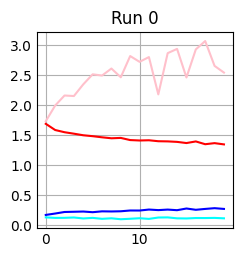

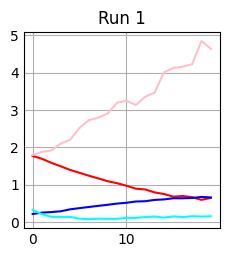

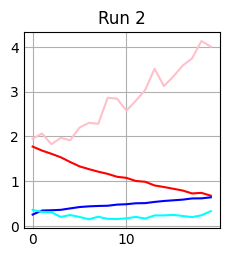

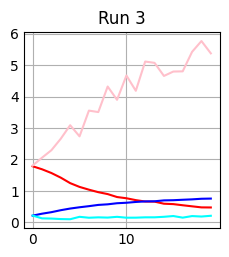

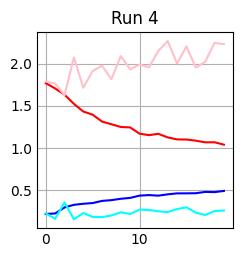

In [24]:
indxs = get_k_indx(k, len(ys))
models = []

for i in range(k_limit):
    train_indx, val_indx, test_indx  = indxs[i]
    
    xs_global_i = xs_global[train_indx]
    xs_global_i_val = xs_global[val_indx]
    xs_global_i_test = xs_global[test_indx]
    
    xs_upper_i = xs_upper[train_indx]
    xs_upper_i_val = xs_upper[val_indx]
    xs_upper_i_test = xs_upper[test_indx]
    
    xs_lower_i = xs_lower[train_indx]
    xs_lower_i_val = xs_lower[val_indx]
    xs_lower_i_test = xs_lower[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]
    
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(ys_i),
                                                 y=ys_i)
    available_classes = np.unique(ys_i)
    weight_training_classes = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
    }
    
    for indx, value in enumerate(class_weights):
        weight_training_classes[available_classes[indx]] = value

    print(weight_training_classes)

    model = get_model()

    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20)
    ]
    
    hist = model.fit(
        x=[
            xs_global_i, 
            xs_upper_i,
            xs_lower_i], y=ys_i, 
        validation_data=([
            xs_global_i_val,
            xs_upper_i_val,
            xs_lower_i_val], ys_i_val),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #callbacks=model_callbacks,
        verbose=VERBOSE)
    
    models.append(model)
    
    # visualizing losses and accuracy
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['accuracy']
    val_acc    = hist.history['val_accuracy']
    xc         = range(len(hist.history['loss']))    
    
    plt.figure()
    plt.title(f'Run {i}')
    plt.plot(xc, train_loss, color='red')
    plt.plot(xc, val_loss, color='pink')
    plt.plot(xc, train_acc, color='blue')
    plt.plot(xc, val_acc, color='cyan')
    
    y_pred = model.predict([
        xs_global_i_test,
        xs_upper_i_test,
        xs_lower_i_test],verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(ys_i_test, y_pred_bool))

# Model Serialization 

In [25]:
serialize = False
best_model = 2

In [26]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe_no-aug_005')

In [27]:
if serialize:
    model = models[best_model]
    model.save(dir_model)